# Import Features and Build Session

In [4]:
!pip install pyspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install findspark

tar: spark-3.2.0-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [5]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, translate, trim
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql import functions as F
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("Fraud").appName("Fraud").config("spark.sql.pivotMaxValues", 1000000).config("spark.driver.memory", "8g").config("spark.executor.memory", "8g").getOrCreate()
sc = spark.sparkContext

sqlContext = SQLContext(sc)

# Import data

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
import pandas as pd
df_credit = sqlContext.read.csv("/content/drive/MyDrive/Big data 2024/CSV 2/creditcard.csv", header=True, inferSchema = True)
df_credit.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

In [8]:
num_columns = len(df_credit.columns)
print("Number of columns:", num_columns)

Number of columns: 31


In [9]:
df_credit.count()

284807

In [10]:
df_credit.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [11]:
df_credit.select([count(when(col(c).isNull(), c)).alias(c) for c in df_credit.columns]).show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



the data is clean

# Modelling

In [13]:
from pyspark.ml.feature import StandardScaler, VectorAssembler

# Scale 'Time' and 'Amount'
assembler = VectorAssembler(inputCols=["Time", "Amount"], outputCol="scaled_features")
data_assembled = assembler.transform(df_credit)

scaler = StandardScaler(inputCol="scaled_features", outputCol="scaled_features_scaled")
scaler_model = scaler.fit(data_assembled)
data_scaled = scaler_model.transform(data_assembled)


In [23]:
feature_columns = df_credit.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_prepared = assembler.transform(data_scaled).select("features", "Class")


In [15]:
train_data, test_data = data_prepared.randomSplit([0.8, 0.2], seed=1234)


In [16]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='Class')
lr_model = lr.fit(train_data)


In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


In [19]:
predictions = lr_model.transform(test_data)

from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate Area Under ROC
evaluator_roc = BinaryClassificationEvaluator(labelCol='Class')
roc_auc = evaluator_roc.evaluate(predictions, {evaluator_roc.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(roc_auc))

# Evaluate accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='Class', metricName='accuracy')
accuracy = evaluator_accuracy.evaluate(predictions)
print("Test Accuracy: " + str(accuracy))


Test Area Under ROC: 0.9729136396818178
Test Accuracy: 0.9991865893337105


The fraud detection model achieved a high Area Under ROC (0.973), indicating strong performance in distinguishing between fraud and non-fraud transactions. Additionally, the model achieved a high accuracy of 99.92%, suggesting it correctly predicted the class for the vast majority of transactions in the test dataset.

# Visualization

In [25]:
import pandas as pd
predictions_pd = predictions.select("Class", "prediction").toPandas()

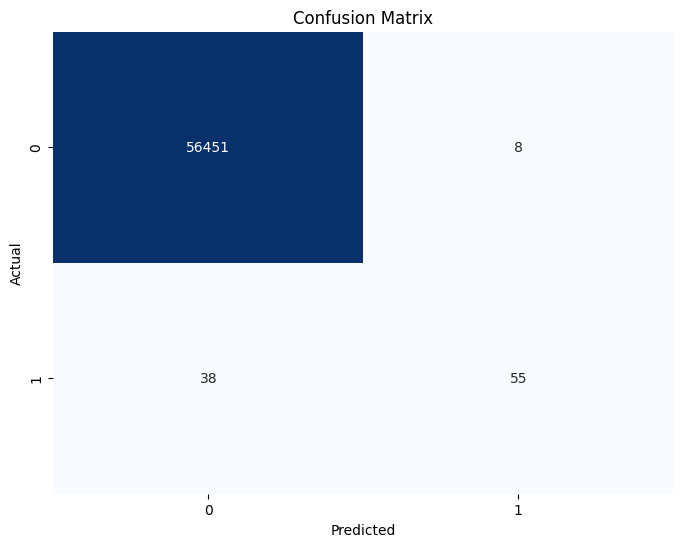

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
conf_matrix = confusion_matrix(predictions_pd['Class'], predictions_pd['prediction'])

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
